In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("lab07_simple_contagion.ipynb")

In [3]:
#from array import array
import pandas as pd
from IPython.core.display import HTML
from datascience import *

import matplotlib
from matplotlib import animation as animation
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('fivethirtyeight')

import networkx as nx

from ipywidgets import interact, interactive, fixed, interact_manual, widgets

# Lab 07: Centrality and Simple Contagion

Today, we're going to talk about two topics. First, we're going to talk about *centrality*. We covered centrality earlier in the semester, but as a reminder, we think of a node as being central when it is in the middle of the network in some way. There are many different ways of defining this concept precisely; we'll look at one example today.

Next, we're going to start to explore simple contagion on networks. By simple contagion, we mean phenomena that spreads without a decision-making process. For example, disease, information, or influence can spread through a network simply through exposure.

We look at these two topics together because we expect that central nodes will play an important role in simple contagion within networks. 

### Centrality

So far, we have thought mostly about network structure and how it might result from various social processes like homophily or triadic closure. Today, we're going to change our focus to how stuff--such as information, resources, or diseases--can spread across networks.

First, we're going to investigate a network metric called *betweenness centrality* which gets at the concept of how important a node is in how things spread across networks.

The betweenness centrality of a node $v$ is defined as the fraction of all shortest paths between all pairs of nodes in the network that pass through $v$.

Mathematically, this [can be written](https://en.wikipedia.org/wiki/Betweenness_centrality)

$$bc(v) = \sum_{s, t \in V} \frac{\sigma(s, t | v)}{\sigma(s, t)},$$

where 

* $bc(v)$ is the betweenness centrality of node $v$
* $\sigma(s, t | v)$ is the number of the shortest paths between node $s$ and node $t$ that goes through $v$
* $\sigma(s,t)$ is the number of shortest paths between node $s$ and node $t$ (note that there can be more than one) 

Note that the $s$ and $t$ vary over all pairs of nodes *not counting* the node $v$ whose betweenness is being calculated.

<img src="example_network.png">

Betweenness of node 3:

1 <-> 2 contributes 1<br>
1 <-> 4 contributes 1<br>
2 <-> 4 contributes 1<br>

All other pairs contribute 0.

So, betweenness centrality for node 3 is equal to 3.


### Contagion

The second concept for today is a simple but very useful model for the spread of an infectious disease, called the SIR model. SIR stands for the three different states that each person in the population can be in:

* Susceptible
* Infected
* Recovered / Removed

The idea is that people can only move through the states according to the diagram below: that is, susceptible people can become infected and, once infected, people recover. Once they have recovered, they cannot be infected again, so they are immune.

We'll work with one main parameter in our exploration here:

* $\beta$ (beta) - probability of a susceptible node getting infected due to a connection to an infected neighbor

Note that beta is defined as the probability a node is infected due to contact with one *infected neighbor*. If a node has several infected neighbors, the total probability that the node will get infected increases.

<img src='sir_diagram.png'>

### Simulating an SIR epidemic

In [15]:
# Rough outline:
#
# randomly pick a starting node to infect
#
# while any infected
#    get neighbors of infected
#    set infected to recovered
#    neighbors become infected with prob beta * # infected contacts
#    record how many were infected

In [16]:
def set_status(net, ids, value):
    """
    set the value of the 'status' attribute for the nodes with the given ids
    in the given network
    """
    nx.set_node_attributes(net, 
                           name = 'status', 
                           values = dict([x for x in zip(ids, [value]*len(ids))])) # this creates the attribute dictionary 

def get_status(net, ids):
    """
    get the value of the 'status' attributes for the nodes 
    with given ids in the given network
    """
    dat = nx.get_node_attributes(net, 'status')
    return([dat[x] for x in ids]) 

def count_infected_nodes(net):
    return(np.sum(np.array(list(nx.get_node_attributes(net, 'status').values())) == 'infected')) # count how many nodes have the attribute as "infected"

In [17]:
def sim_epidemic(net, start_nodes=None, innoculated_nodes=None, beta=0.3, draw=False):
    
    # all nodes start susceptible
    set_status(net, net.nodes(), 'susceptible')

    # innoculated nodes start as recovered
    # the default setting for this input is None
    if innoculated_nodes is not None:
        set_status(net, innoculated_nodes, 'innoculated') # if innoculated_nodes is not set to none, set it as attribute values
    else:
        innoculated_nodes = []

    eligible_to_start = [x for x in net.nodes() if x not in innoculated_nodes]   # the dynamics will start with the ones that are not innoculated
        
    # if no start_nodes specified, pick one node at random as the seed
    if start_nodes is None:
        infected_nodes = np.random.choice(eligible_to_start, 1)
    else:
        infected_nodes = start_nodes

    
    set_status(net, infected_nodes, 'infected')

    incidence = [len(infected_nodes)] # to record the infection incidences
    
    if draw:
        status_cmap = {'susceptible' : '#00FF00', 'infected' : '#FF0000', 'recovered' : '#000000', 'innoculated' : '#0000FF'}
        status_cmap = {'susceptible' : 'green', 'infected' : 'red', 'recovered' : 'yellow', 'innoculated' : 'black'}
        pos = nx.random_layout(net)
        
        #fig_nums = []

    while count_infected_nodes(net) > 0: # this loop will go on as long as the number of infected nodes is > 0

        if draw:
            next_fig, next_ax = plt.subplots() 
            plt.figure(nx.draw(net, 
                               pos=pos,
                               cmap=status_cmap, 
#                                node_color=[status_cmap[net[node]['status']] for node in net.nodes()]));
                               node_color=[status_cmap[x] for x in get_status(net, net.nodes())]));
#                                node_color=[status_cmap[net.node[node]['status']] for node in net]));
            #nx.draw(net, 
            #                   pos=pos,
            #                   cmap=status_cmap, 
            #                   node_color=[status_cmap[net.node[node]['status']] for node in net],
            #                   ax=next_ax)
            #fig_nums.append(plt.gcf().number)
        
        ## get neighbors of infected nodes
        neighbors = [net.neighbors(x) for x in infected_nodes]

        # see http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
        neighbors = [item for sublist in neighbors for item in sublist]        
        neighbors_status = np.array(get_status(net, neighbors))

        ## set infected nodes to recovered
        set_status(net, infected_nodes, 'recovered')

        ## infect susceptible neighbors with probability beta x number of infected contacts
        ## (a node with more than one infected contact will have more than one draws at being infected here)
        neighbors = [x[0] for x in zip(neighbors, neighbors_status) if x[1] == 'susceptible']
        infect_draws = np.random.random_sample(len(neighbors))
        #print(infect_draws)
        to_infect = list(np.array(neighbors)[np.where(infect_draws < beta)])

        num_infected_this_round = len(set(to_infect))
        
        set_status(net, to_infect, 'infected')
        infected_nodes = to_infect

        ## record number infected this round (also called incidence at this time step)
        incidence.append(num_infected_this_round)
    
    return incidence # finally, the function will return an array of number that records how many nodes are infected each round

### SIR model: illustration

The code above takes a given network and simulates an SIR epidemic on it. It returns a list that has the *incidence* -- that is, the number of new infections -- at each time step. By adding these values up, we can tell how many people ended up being infected by the outbreak.

In [20]:
np.random.seed(seed=101)
er_net_example = nx.erdos_renyi_graph(n=20, p=.2)

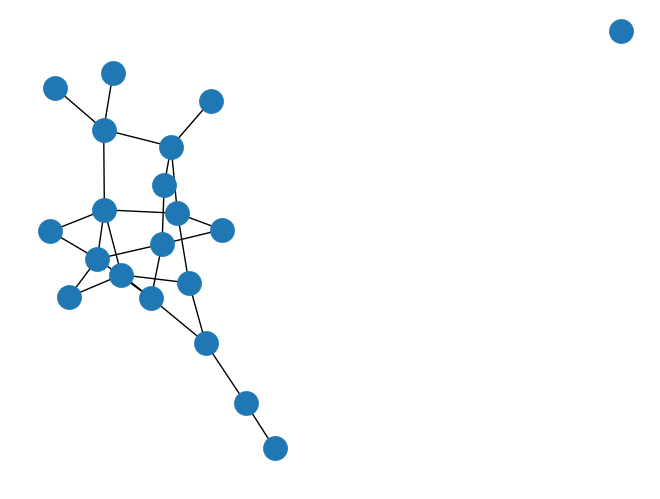

In [21]:
nx.draw(er_net_example)

/opt/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


[1, 2, 3, 3, 2, 1, 0]

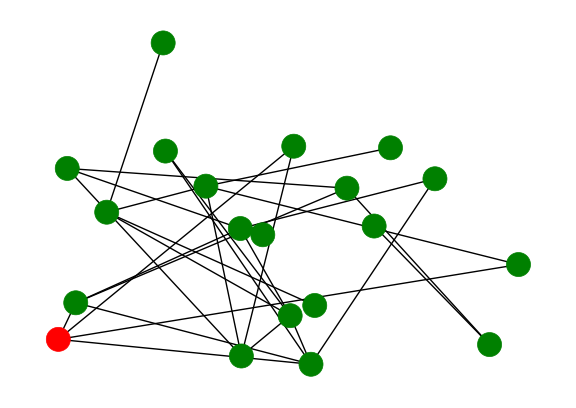

<Figure size 640x480 with 0 Axes>

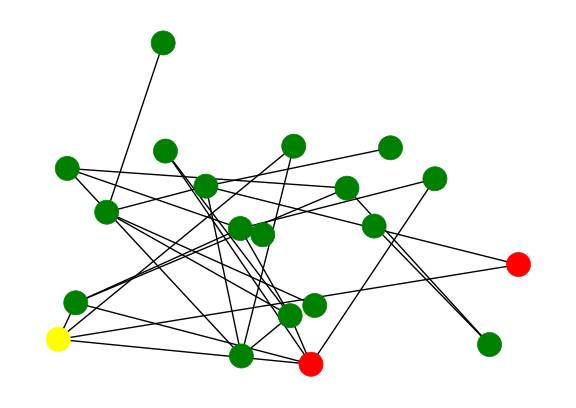

<Figure size 640x480 with 0 Axes>

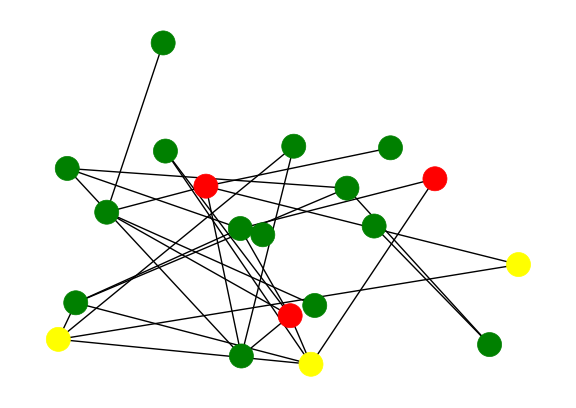

<Figure size 640x480 with 0 Axes>

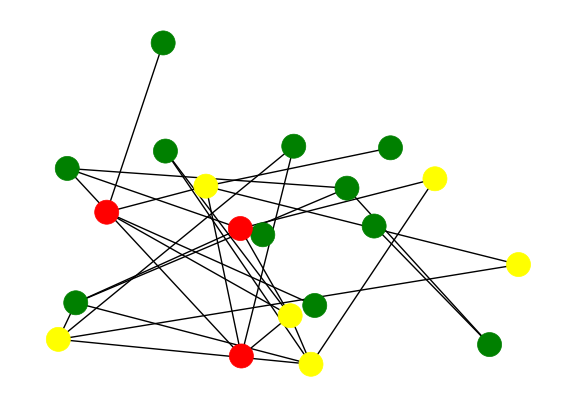

<Figure size 640x480 with 0 Axes>

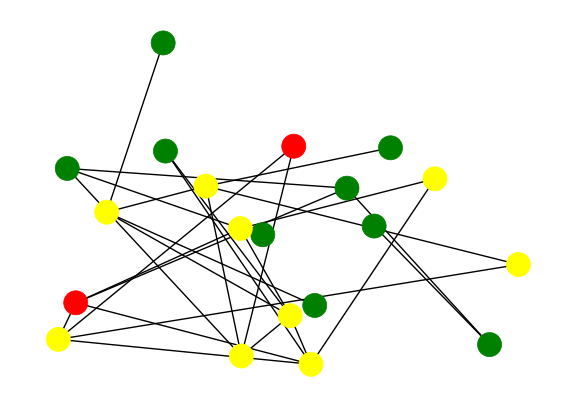

<Figure size 640x480 with 0 Axes>

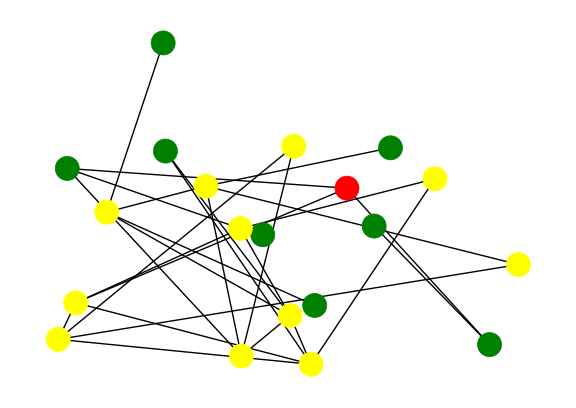

<Figure size 640x480 with 0 Axes>

In [22]:
np.random.seed(seed=100)
res = sim_epidemic(er_net_example, beta=.3, draw=True)
res

### SIR model in Erdos-Renyi random networks

The SIR model is *stochastic*, meaning that it involves randomness: every time you simulate the course of an epidemic using an SIR model, you can get different outcomes. (We saw something similar when we looked at how to generate random networks using the ER model.)

We'll start studying the SIR model by running it repeatedly on the same network and looking at how much variation there is in the resulting epidemic.

We will first run the SIR model once on the network `er_net_example` and calculate how many people get infected in total.

In [26]:
total_infected = np.sum(sim_epidemic(er_net_example, beta=.3))
total_infected

7

<!-- BEGIN QUESTION -->

# Question 1:
Write some code that runs 1000 simulated ER epidemics on the network `er_net_example` with beta of 0.3. Make a histogram that shows how much variation there is in the total number of people infected in each simulation. (Recall that we generated `er_net_example` above, using the ER random network model.)

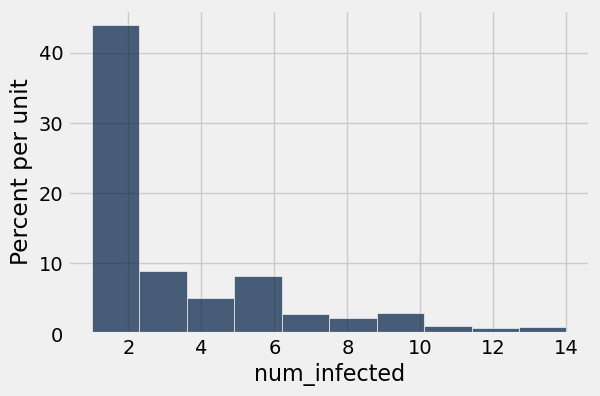

In [28]:
num_infected = make_array()
for _ in range(1000):
    num_infected = np.append(num_infected, np.sum(sim_epidemic(er_net_example, beta=.3)))
Table().with_column('num_infected', num_infected).hist()

<!-- END QUESTION -->

# Question 2

Write a simulation that varies the beta parameter and studies how the number of people infected varies as beta increases from 0.1 to 0.8. Use the network `er_net_example` for your simulations.

In [30]:
# BEGIN SOLUTION NO PROMPT
num_infected = make_array()
beta_val = make_array()
## vary beta across the range 0.1 to 0.8, with the step of 0.1 (np.arange function)
for cur_beta in np.arange(.1, .9, .1):
    ## for each value of beta, run 1000 simulated epidemics
    for _ in range(1000):
        num_infected = np.append(num_infected, np.sum(sim_epidemic(er_net_example, beta=cur_beta)))
        beta_val = np.append(beta_val, cur_beta)
beta_sim_res = Table().with_columns(['beta', beta_val,
                                     'num_infected', num_infected])
beta_sim_res

beta,num_infected
0.1,1
0.1,1
0.1,1
0.1,1
0.1,1
0.1,1
0.1,1
0.1,2
0.1,1
0.1,1


In [31]:
grader.check("q2")

q2 results: All test cases passed!

<!-- BEGIN QUESTION -->

# Question 3 
Now make a scatter plot of the value of beta (x axis) to the average number of people infected across the simulations for each value of beta (y axis).

*Hint: If you don't know what "group" does, you can review previous assignments or check out the python documentation: https://docs.python.org/3/howto/regex.html*


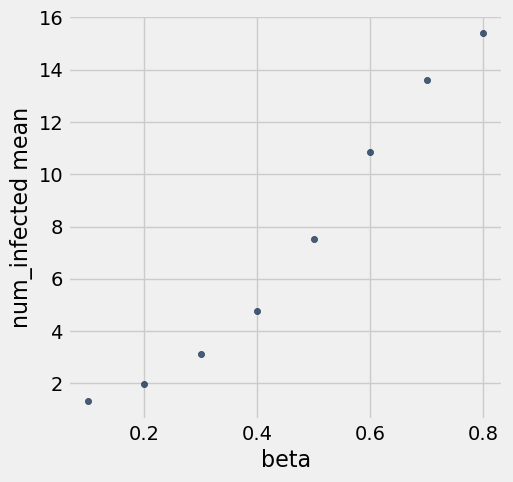

In [33]:
beta_sim_res.group('beta', np.mean).scatter('beta', 'num_infected mean')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Question 4

Now let's visualize the results in a second way. Make a scatterplot that compares the value of beta (x axis) to the number of people infected in each simulation (y axis). (Use the `alpha` parameter to avoid misleading results due to overplotting.)

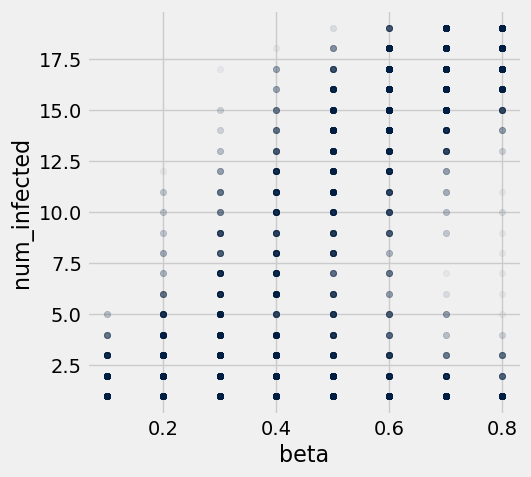

In [35]:
beta_sim_res.scatter('beta', 'num_infected', alpha=.05)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Question 5
What do you conclude from the two plots above? How does increasing beta affect the number of people who are infected in an SIR model on the network `er_net_example`? Describe the effects separately for the two plots.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Innoculating nodes

The function `sim_epidemic` can take an optional parameter called `innoculated_nodes`, which is a list with the ids of nodes that are assumed to be impervious to the infection.

For example, the following code would run a simulation with node number 10 innoculated:

`sim_epidemic(er_net_example, innoculated_nodes=[10], beta=.3)`

We might hope that if we innoculate the right node, we can reduce the total number of people who get infected by the epidemic. The question is: what kind of nodes should be innoculated?

# Question 6 

Write a simulation that explores what impact innoculating each node in the network has on the number of people that are infected. You should loop through each node in the network `er_net_example` and simulate 1000 ER epidemics with that node innoculated. (So, only one node is ever innoculated.) Keep track of which node was innoculated and the number of people that were infected; put these simulation results into a Table called `sim_res`.


In [41]:
# BEGIN SOLUTION NO PROMPT
sim_beta = 0.3
node_ids = make_array()
tot_num_infected = make_array()
for cur_node in er_net_example.nodes():
    for _ in range(1000):
        tot_num_infected = np.append(tot_num_infected, 
                                     np.sum(sim_epidemic(er_net_example, 
                                                         innoculated_nodes=[cur_node], 
                                                         beta=sim_beta)))
        node_ids = np.append(node_ids, cur_node)       
sim_res = Table().with_columns(['node_id', node_ids,
                                'tot_infected', tot_num_infected])
sim_res
# END SOLUTION

node_id,tot_infected
0,3
0,1
0,1
0,7
0,7
0,2
0,3
0,2
0,1
0,5


In [42]:
grader.check("q6")

q6 results: All test cases passed!

# Question 7 
Your simulation results have 1000 repetitions for each innoculated node. Make an aggregated Table called `sim_res_agg` which has the node id and the average total number infected across all of the simulation runs where that node id was innoculated.   
*[Hint: Use `group` here.]*

In [44]:
sim_res_agg = sim_res.group('node_id', np.mean)
sim_res_agg

node_id,tot_infected mean
0,3.051
1,2.499
2,2.631
3,2.74
4,3.049
5,2.712
6,2.549
7,3.017
8,2.682
9,3.077


In [45]:
grader.check("q7")

q7 results: All test cases passed!

Now we make a Table that has the id of each node in the network, its degree, and its betweenness centrality.

"betweenness_centrality" is a function built in the networkx package.

In [47]:
try:
    node_dat = Table().with_columns('node_id', er_net_example.nodes(),
                                'betweenness_centrality', nx.betweenness_centrality(er_net_example).values(),
                                'degree', nx.degree(er_net_example).values())
except:
    node_dat = Table().with_columns('node_id', er_net_example.nodes(),
                                'betweenness_centrality', nx.betweenness_centrality(er_net_example).values(),
                                'degree',[y for x,y in  nx.degree(er_net_example)])
    pass

node_dat

node_id,betweenness_centrality,degree
0,0,1
1,0.244639,5
2,0.151072,4
3,0.218324,4
4,0.0994152,2
5,0.194347,3
6,0.134016,5
7,0,1
8,0.104483,4
9,0,2


Now we can join the `node_dat` table onto the `sim_res_agg` table so that you have a table that has node characteristics (degree and betweenness centrality) and the average total number infected when that node is innoculated.

In [49]:
res = sim_res_agg.join('node_id', node_dat)
res

node_id,tot_infected mean,betweenness_centrality,degree
0,3.051,0,1
1,2.499,0.244639,5
2,2.631,0.151072,4
3,2.74,0.218324,4
4,3.049,0.0994152,2
5,2.712,0.194347,3
6,2.549,0.134016,5
7,3.017,0,1
8,2.682,0.104483,4
9,3.077,0,2


We can now make a scatterplot that shows the relationship between the betweenness centrality (x axis) and the average total number infected (y axis).

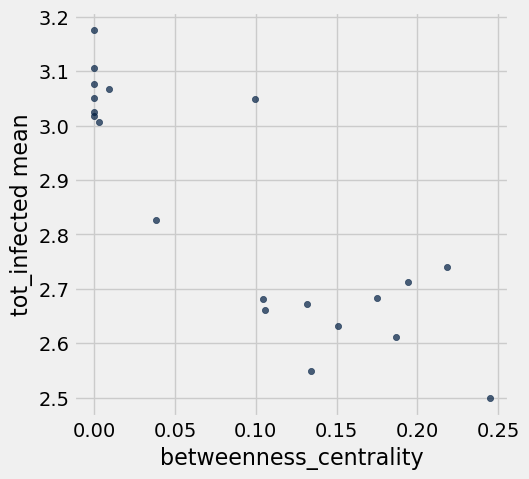

In [51]:
res.scatter('betweenness_centrality', 'tot_infected mean')

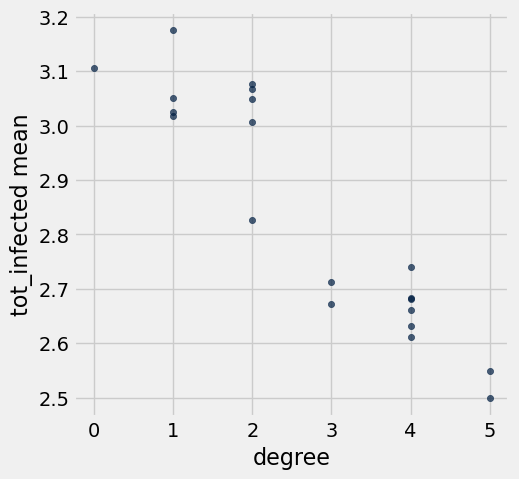

In [52]:
res.scatter('degree', 'tot_infected mean')

<!-- BEGIN QUESTION -->

# Question 8
Which metric of centrality (degree or betweenness centrality) appears to be a better guide to targeting nodes for innoculation in the ER network?

_Type your answer here, replacing this text._

<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [57]:
grader.check_all()

q2 results: All test cases passed!

q6 results: All test cases passed!

q7 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Please upload the .zip file to Gradescope.

In [59]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q2 results: All test cases passed!

    q6 results: All test cases passed!

    q7 results: All test cases passed!
